# Classification

## Objectives

*  Fit and evaluate a classification model to predict if a prospect will churn or not.

## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot



---

# Change working directory

Change the working directory from its current folder to its parent folder


In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Film_Hit_prediction/jupyter_notebooks'

Make the parent of the current directory the new current directory.


In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/Film_Hit_prediction'

---

# Load Data 

Load Data

In [5]:
import pandas as pd
import pickle

# Load the splits for modeling
X_train = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/X_train.pkl')
X_test = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/X_test.pkl')
y_train = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_train.pkl')
y_test = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_test.pkl')


print("Dataset shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


Dataset shapes:
X_train shape: (813, 1354)
y_train shape: (813,)
X_test shape: (3284, 1354)
y_test shape: (3284,)


---

# Step 2: ML Pipeline with all data

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define models

models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
        }
    },
 
}


# Set up and train model

In [7]:


results = {}
best_models = {}

for name, model_info in models.items():
    print(f"\nTraining {name}...")

    # GridSearchCV performs the hyperparameter optimization
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs= 2
    )
    
    grid_search.fit(X_train, y_train)



Training Linear Regression...



Training Ridge...

Training Lasso...

Training Random Forest...


# Train Models and Evaluate Performance

In [8]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import joblib

results = {}
best_models = {}

for name, model_info in models.items():
    print(f"\nTraining {name}...")
    
    # GridSearchCV performs the hyperparameter optimization
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=2
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Store the best model and make predictions
    best_models[name] = grid_search.best_estimator_
    y_pred = grid_search.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2,
        'Best Parameters': grid_search.best_params_
    }
    
    # Print results
    print(f"\nResults for {name}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    print(f"Best Parameters: {grid_search.best_params_}")


Training Linear Regression...

Results for Linear Regression:
RMSE: 66641600665.70
R2 Score: -4441102939287149608960.00
Best Parameters: {}

Training Ridge...

Results for Ridge:
RMSE: 0.71
R2 Score: 0.50
Best Parameters: {'alpha': 10.0}

Training Lasso...

Results for Lasso:
RMSE: 0.64
R2 Score: 0.59
Best Parameters: {'alpha': 0.1}

Training Random Forest...

Results for Random Forest:
RMSE: 0.58
R2 Score: 0.66
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


# Save Best Performing Model

In [9]:
import os
import joblib

best_model = None
best_score = float('-inf')

# Find the best model based on R2 score
for name, metrics in results.items():
    if metrics['R2 Score'] > best_score:
        best_score = metrics['R2 Score']
        best_model = best_models[name]


# Save the best model using joblib
joblib.dump(best_model, '/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/film_revenue_model.joblib')

print("Best model saved successfully!")


Best model saved successfully!


## Assess feature importance

Loaded model type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>

Top 10 Most Important Features:
                     Feature  Importance
1199                  budget    0.596108
187               popularity    0.176355
989                  runtime    0.065428
775        budget_per_minute    0.032461
156   company_DreamWorks SKG    0.013068
387        other_actor_count    0.009961
62      other_producer_count    0.006091
1222       company_Lucasfilm    0.004652
969     other_director_count    0.003188
1244                   Drama    0.002993


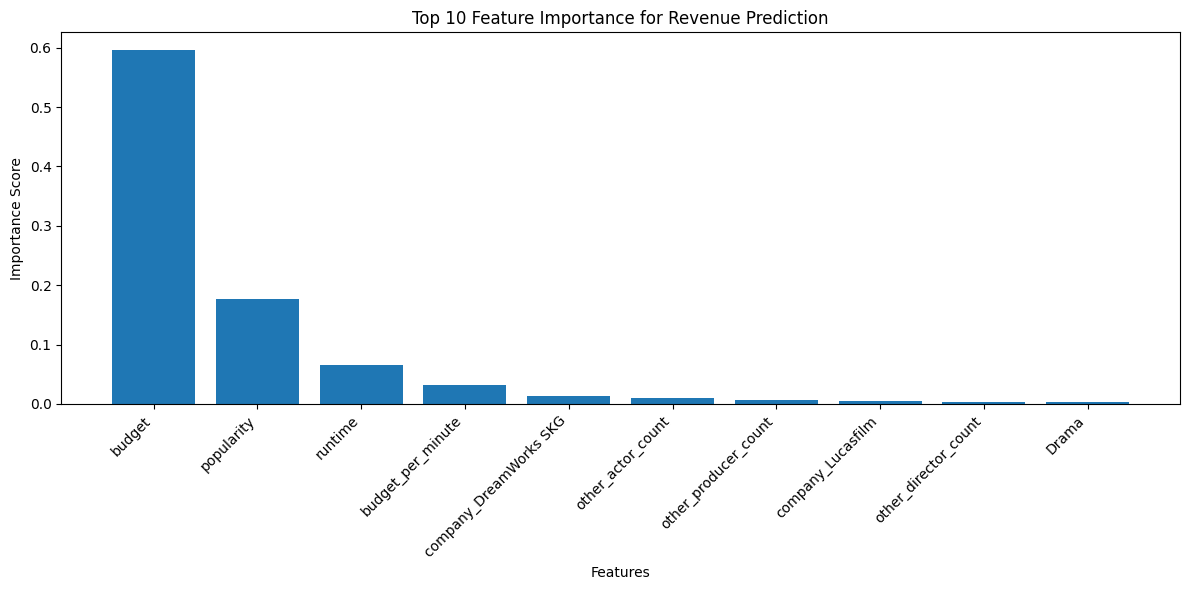

In [10]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved Random Forest model
model_path = '/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/film_revenue_model.joblib'
loaded_model = joblib.load(model_path)

print("Loaded model type:", type(loaded_model))


# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': loaded_model.feature_importances_
})

# Sort features by importance in descending order
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Print top 10 most important features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot the top 10 feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importance for Revenue Prediction')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


# Prediction Model


Create a function to make predictions for new movies based on parameters:
-  budget (float): Movie budget in dollars
- language (str): Original language (e.g., 'en' for English)
- genres (list): List of genres (e.g., ['Action', 'Adventure'])
    
 Returns:
- float: Predicted revenue and profit

New model

In [14]:
import pandas as pd
import numpy as np
import pickle
import joblib
from sklearn.preprocessing import StandardScaler


# First load all necessary models and data
def load_models_and_data():
    """
    Load all necessary models, encoders, and data files
    """
    try:
        print("Loading models and data...")
        
        # Load the trained model
        print("Loading revenue prediction model...")
        model = joblib.load('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/film_revenue_model.joblib')
        print("Model loaded successfully!")
        
        # Load the training and test data
        print("Loading training and test data...")
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/train_df_engineered.pkl', 'rb') as f:
            train_df = pickle.load(f)
            
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/test_df_engineered.pkl', 'rb') as f:
            test_df = pickle.load(f)
            
        # Load encoders and filters
        print("Loading encoders...")
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/cleaned/encoders_and_filters.pkl', 'rb') as f:
            encoders = pickle.load(f)

        # Load feature engineering data
        print("Loading feature engineering data...")
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/feature_engineering_data.pkl', 'rb') as f:
            eng_data = pickle.load(f)
            
        print("All models and data loaded successfully!")
        
        return {
            'train_df': train_df,
            'test_df': test_df,
            'encoders': encoders,
            'eng_data': eng_data,
            'model': model,
            'feature_names': train_df.columns
        }
    except Exception as e:
        print(f"Error loading models and data: {str(e)}")
        print("Error details:")
        import traceback
        traceback.print_exc()
        return None
    
    # Load all models and data once
print("Initializing prediction system...")
MODELS_AND_DATA = load_models_and_data()

Initializing prediction system...
Loading models and data...
Loading revenue prediction model...
Model loaded successfully!
Loading training and test data...
Loading encoders...
Loading feature engineering data...
All models and data loaded successfully!


In [ ]:
import pandas as pd
import numpy as np
import pickle
import joblib
from sklearn.preprocessing import StandardScaler


def predict_movie_revenue(
    budget,
    runtime,
    genres,  # list of genres
    language,
    production_company,
    production_country,
    actor1,
    actor2,
    crew_director,
    crew_writer,
    crew_producer
):
    try:
        if MODELS_AND_DATA is None:
            raise ValueError("Models and data not properly loaded")
            
        # Unpack models and data
        train_df = MODELS_AND_DATA['train_df']
        encoders = MODELS_AND_DATA['encoders']
        eng_data = MODELS_AND_DATA['eng_data']
        model = MODELS_AND_DATA['model']
        feature_names = MODELS_AND_DATA['feature_names']
        scaler = eng_data['scaler']
        
        print(f"Number of features: {len(feature_names)}")
        

        # Load the full list of features
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/all_features.pkl', 'rb') as f:
            all_features = pickle.load(f)

        # Initialize features dictionary with all features set to 0 by default
        features = {col: 0 for col in all_features}
        
        # Most important numeric features first
        features['budget'] = budget
        features['popularity'] = 0  # Default value for new movies
        features['runtime'] = runtime
        features['budget_per_minute'] = budget / runtime if runtime > 0 else 0

        # Set actor features
        if f'cast_{actor1}' in features:
            features[f'cast_{actor1}'] = 1

        if f'cast_{actor2}' in features:
            features[f'cast_{actor2}'] = 1

        # Update 'other_actor_count' if the actors are not in the top list
        features['other_actor_count'] = 2 - sum(features[f'cast_{actor}'] for actor in [actor1, actor2] if f'cast_{actor}' in features)
        
        # Set director features
        if f'crew_director_{crew_director}' in features:
            features[f'crew_director_{crew_director}'] = 1
            features['other_director_count'] = 0
        else:
            features['other_director_count'] = 1

        # Set writer features
        if f'crew_writer_{crew_writer}' in features:
            features[f'crew_writer_{crew_writer}'] = 1
            features['other_writer_count'] = 0
        else:
            features['other_writer_count'] = 1
        
        # Set producer features
        if f'crew_producer_{crew_producer}' in features:
            features[f'crew_producer_{crew_producer}'] = 1
            features['other_producer_count'] = 0
        else:
            features['other_producer_count'] = 1


        # Important categorical features
        features['company_DreamWorks SKG'] = 1 if production_company == 'DreamWorks SKG' else 0
        features['company_Lucasfilm'] = 1 if production_company == 'Lucasfilm' else 0
        features['Drama'] = 1 if 'Drama' in genres else 0
        
        # Other important count features
        features['other_actor_count'] = 0  # Will be updated later
        features['other_director_count'] = 0  # Will be updated later
        features['other_producer_count'] = 0  # Will be updated later
        
        # Basic features
        features['is_long_movie'] = 1 if runtime > 120 else 0
        features['language_encoded'] = encoders['language_encoder'].transform([language])[0]
        features['is_english'] = 1 if language == 'en' else 0
        
        # Transform companies using mlb
        companies_encoded = encoders['mlb_companies'].transform([[production_company]])[0]
        company_columns = [col for col in feature_names if col.startswith('company_')]
        for i, col in enumerate(company_columns):
            features[col] = companies_encoded[i] if i < len(companies_encoded) else 0
            
        # Transform countries using mlb
        countries_encoded = encoders['mlb_countries'].transform([[production_country]])[0]
        country_columns = [col for col in feature_names if col.startswith('country_')]
        for i, col in enumerate(country_columns):
            features[col] = countries_encoded[i] if i < len(countries_encoded) else 0
        
        # Set genres
        for genre in feature_names:
            if genre in genres:
                features[genre] = 1
            elif genre in encoders['genre_columns']:
                features[genre] = 0
                
        # Set cast features
        cast_columns = [col for col in feature_names if col.startswith('cast_')]
        for col in cast_columns:
            features[col] = 1 if col in [f'cast_{actor1}', f'cast_{actor2}'] else 0
            
        # Set crew features
        crew_director_encoded = encoders['mlb_crew'].transform([[crew_director]])[0]
        crew_writer_encoded = encoders['mlb_crew'].transform([[crew_writer]])[0]
        crew_producer_encoded = encoders['mlb_crew'].transform([[crew_producer]])[0]
        
        crew_columns = [col for col in feature_names if col.startswith('crew_')]
        director_columns = [col for col in crew_columns if 'director' in col.lower()]
        writer_columns = [col for col in crew_columns if 'writer' in col.lower()]
        producer_columns = [col for col in crew_columns if 'producer' in col.lower()]
        
        # Set crew encoded values
        for i, col in enumerate(director_columns):
            features[col] = crew_director_encoded[i] if i < len(crew_director_encoded) else 0
        for i, col in enumerate(writer_columns):
            features[col] = crew_writer_encoded[i] if i < len(crew_writer_encoded) else 0
        for i, col in enumerate(producer_columns):
            features[col] = crew_producer_encoded[i] if i < len(crew_producer_encoded) else 0
            
        # Update other counts
        features['other_actor_count'] = 2 - sum(1 for col in [f'cast_{actor1}', f'cast_{actor2}'] if col in cast_columns)
        features['other_director_count'] = 0 if any(crew_director_encoded) else 1
        features['other_writer_count'] = 0 if any(crew_writer_encoded) else 1
        features['other_producer_count'] = 0 if any(crew_producer_encoded) else 1
        
        # Create DataFrame with all features
        pred_df = pd.DataFrame([features])
        
        # Add any missing columns with 0s
        for col in feature_names:
            if col not in pred_df.columns:
                pred_df[col] = 0
                
        # Ensure column order matches training data
        pred_df = pred_df[feature_names]
        
        # Most important features to be scaled
        important_numeric_features = [
            'budget',
            'popularity',
            'runtime',
            'budget_per_minute'
        ]
        
        print("\nImportant numeric features shape:", pred_df[important_numeric_features].shape)
        # Scale the numeric features
        pred_df[important_numeric_features] = scaler.transform(pred_df[important_numeric_features])
        
        # Make prediction
        predicted_revenue = model.predict(pred_df)[0]
        
        print("\nPrediction successful!")
        return predicted_revenue
        
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        print(f"Error details: {type(e).__name__}")
        import traceback
        traceback.print_exc()
        return None

# Example usage
if __name__ == "__main__":
    test_movie = {
        'budget': 150000000,
        'runtime': 120,
        'genres': ['Action', 'Adventure', 'Science Fiction'],
        'language': 'en',
        'production_company': 'Marvel Studios',
        'production_country': 'United States of America',
        'actor1': 'Chris Hemsworth',
        'actor2': 'Robert Downey Jr.',
        'crew_director': 'Joss Whedon',
        'crew_writer': 'Joss Whedon',
        'crew_producer': 'Kevin Feige'
    }
    
    prediction = predict_movie_revenue(**test_movie)
    
    if prediction is not None:
        print(f"\nPredicted Revenue: ${prediction:,.2f}")

Number of features: 1355

Important numeric features shape: (1, 4)
Error in prediction: X has 4 features, but StandardScaler is expecting 156 features as input.
Error details: ValueError


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Joss Whedon'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Kevin Feige'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
Traceback (most recent call last):
  File "/tmp/ipykernel_1250/3095762158.py", line 128, in predict_movie_revenue
    pred_df[important_numeric_features] = scaler.transform(pred_df[important_numeric_features])
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/preprocessing/_data.py", line 883, in transform
    X = self._validate_data(X, reset=False,
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/base.py", line 437, in _validate_data
    self._check_n_features(X, reset=reset)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklea

old modeling

Testing

In [12]:
test_cases = [
    {'budget': 2000000, 'language': 'en', 'genres': ['horror']},  # Low budget horror
    {'budget': 300000000, 'language': 'en', 'genres': ['action', 'adventure']},  # Blockbuster
    {'budget': 90000000, 'language': 'fr', 'genres': ['comedy']},  # Mid-budget foreign
]

for movie in test_cases:
    print("\nTesting:", movie)
    result = predict_movie_metrix(movie['budget'], movie['language'], movie['genres'])


Testing: {'budget': 2000000, 'language': 'en', 'genres': ['horror']}


NameError: name 'predict_movie_metrix' is not defined

# Evaluation


Load model

In [ ]:
import joblib

model_path = "/workspace/Film_Hit_prediction/outputs/models/"  

model = joblib.load(model_path + 'movie_revenue_predictor.joblib')

print("Model loaded:", type(model))

Make predictions on test data 

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Define Genres
all_genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
              'Documentary', 'Drama', 'Family', 'Fantasy', 'History',
              'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
              'TV Movie', 'Thriller', 'War', 'Western', 'Foreign']


#Evaluation
test_predictions = []
test_profit = []

# Get predictions for test set
y_pred = model.predict(X_test_final)
test_predictions = y_pred.tolist()


#Caluclate metrics

print("Revenue Prediction Metrics:")
print(f"R2 Score: {r2_score(y_test_final, test_predictions):.3f}")
print(f"MAE: ${mean_absolute_error(y_test_final, test_predictions):,.2f}")
print(f"RMSE: ${mean_squared_error(y_test_final, test_predictions, squared=False):,.2f}")




Vizualization predictions vs actual values

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_final, y_pred, alpha=0.5)
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'r--', lw=2)

plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Predicted vs Actual Movie Revenue')

# correlation coefficient
correlation = np.corrcoef(y_test_final.squeeze(), y_pred)[0,1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

Residual Analysis

verify size 

Match sizes

In [ ]:
print("Training set shape:", X_train_final.shape)
print("Test set shape:", X_test_final.shape)
print("y_train shape:", y_train_final.shape)
print("y_test shape:", y_test_final.shape)
print("y_pred shape:", y_pred.shape)

In [ ]:
print([var for var in globals() if 'y_' in var])

plot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test_final.values.ravel() - y_pred

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

Learning Curves

In [ ]:
from sklearn.model_selection import learning_curve 

train_sizes, train_scores, test_scores = learning_curve(
    model, 
    X_train_final.values, 
    y_train_final.values,
    cv=5, 
    n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [ ]:
print("\nModel Evaluation Metrics:")
print(f"R² Score: {r2_score(y_test_final, y_pred):.3f}")
print(f"MAE: ${mean_absolute_error(y_test_final, y_pred):.2f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test_final, y_pred)):.2f}")